#Planet Hunters Notebook 2

# Classifying Exoplanets

For satellite missions, NASA needs to be able to process tons and tons of information received by satellites efficiently and effectively. We'll see one approach as to help NASA classify exoplanet stars by using modern machine learning techniques! How better to learn than use raw data from one of NASA's satellites?


The focus of this notebook is classifying exoplanet stars. We'll be:
*   Preprocessing the dataset for the ML models
*   Implementing different ML architectures to see which one performs best
*   Using data augmentation to improve our models' performance!

## Exoplanet Classification




Previously, we were able to visualize data of the training set from Kepler. Now that we better understand the data that we're working with, we can begin to dive into how we can train a computer to classify exoplanet stars, and the difficulties faced when doing so.

We can make use of different architectures and models to explore the best options for classifying exoplanet stars. Our explorations will also help us build intuition of how to analyze and use raw data from a satellite to help plan future missions exploring the abyss that is space around us. Is there life elsewhere? Right now we're not too sure, but identyfying and analyzing exoplanets can help us to better understand where we're most likely to find life!

**IMPORTANT**: Since the calculations used for machine learning can be demanding for a computer, we need to do one step before continuing. We need to go to the 'Runtime' tab, and click on 'Change Runtime Type'; then select **GPU** under the dropdown for Hardware accelerator.

In [ ]:
#@title Run this code to get started
%tensorflow_version 2.x
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTrain.csv'
!wget 'https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTest.csv'

from urllib.request import urlretrieve
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn import  metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from scipy.signal import savgol_filter
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,plot_confusion_matrix,precision_score,recall_score,f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize

df_train = pd.read_csv('exoTrain.csv')
df_train.LABEL = df_train.LABEL -1
df_test = pd.read_csv('exoTest.csv')
df_test.LABEL = df_test.LABEL - 1

--2021-07-28 15:57:44--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTrain.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.120.128, 142.250.128.128, 74.125.70.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.120.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262223348 (250M) [application/octet-stream]
Saving to: ‘exoTrain.csv’

exoTrain.csv        100%[===================>] 250.08M   208MB/s    in 1.2s    

2021-07-28 15:57:45 (208 MB/s) - ‘exoTrain.csv’ saved [262223348/262223348]

--2021-07-28 15:57:45--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Planet%20Hunters/exoTest.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.234.128, 108.177.112.128, 74.125.124.128, ...
Connecting to storage.googleapis

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Remember that `df_train` and `df_test` are the Pandas Dataframes that store our training, validation, and test datapoints. The training dataset is the one we explored last time, and the testing dataset is a new one!

## Understanding our Data



### Data Visualization

Let's make sure that the data we've extracted has properly loaded. **Here, we print the length of each dataframe (`df_train` and `df_test`) and the first five values from `df_train`.**


In [ ]:
print("df_train len:", len(df_train))
print("df_test len:", len(df_test))
print("first 5 values of df train\n")
df_train.head()

df_train len: 5087
df_test len: 570
first 5 values of df train



,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,FLUX.11,FLUX.12,FLUX.13,FLUX.14,FLUX.15,FLUX.16,FLUX.17,FLUX.18,FLUX.19,FLUX.20,FLUX.21,FLUX.22,FLUX.23,FLUX.24,FLUX.25,FLUX.26,FLUX.27,FLUX.28,FLUX.29,FLUX.30,FLUX.31,FLUX.32,FLUX.33,FLUX.34,FLUX.35,FLUX.36,FLUX.37,FLUX.38,FLUX.39,...,FLUX.3158,FLUX.3159,FLUX.3160,FLUX.3161,FLUX.3162,FLUX.3163,FLUX.3164,FLUX.3165,FLUX.3166,FLUX.3167,FLUX.3168,FLUX.3169,FLUX.3170,FLUX.3171,FLUX.3172,FLUX.3173,FLUX.3174,FLUX.3175,FLUX.3176,FLUX.3177,FLUX.3178,FLUX.3179,FLUX.3180,FLUX.3181,FLUX.3182,FLUX.3183,FLUX.3184,FLUX.3185,FLUX.3186,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,1,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,-207.47,-154.88,-173.71,-146.56,-120.26,-102.85,-98.71,-48.42,-86.57,-0.84,-25.85,-67.39,-36.55,-87.01,-97.72,-131.59,-134.80,-186.97,-244.32,-225.76,-229.60,-253.48,-145.74,-145.74,30.47,-173.39,-187.56,-192.88,-182.76,...,-167.69,-56.86,7.56,37.40,-81.13,-20.10,-30.34,-320.48,-320.48,-287.72,-351.25,-70.07,-194.34,-106.47,-14.80,63.13,130.03,76.43,131.90,-193.16,-193.16,-89.26,-17.56,-17.31,125.62,68.87,100.01,-9.60,-25.39,-16.51,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,-86.51,-74.97,-73.15,-86.13,-76.57,-61.27,-37.23,-48.53,-30.96,-8.14,-5.54,15.79,45.71,10.61,40.66,16.70,15.18,11.98,-203.70,19.13,19.13,19.13,19.13,19.13,17.02,-8.50,-13.87,-29.10,-34.29,...,-36.75,-15.49,-13.24,20.46,-1.47,-0.40,27.80,-58.20,-58.20,-72.04,-58.01,-30.92,-13.42,-13.98,-5.43,8.71,1.80,36.59,-9.80,-19.53,-19.53,-24.32,-23.88,-33.07,-9.03,3.75,11.61,-12.66,-5.69,12.53,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,1,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,469.66,462.30,492.23,441.20,483.17,481.28,535.31,554.34,562.80,540.14,576.34,551.67,556.69,550.86,577.33,562.08,577.97,530.67,553.27,538.33,527.17,532.50,273.66,273.66,292.39,298.44,252.64,233.58,171.41,...,-51.09,-33.30,-61.53,-89.61,-69.17,-86.47,-140.91,-84.20,-84.20,-89.09,-55.44,-61.05,-29.17,-63.80,-57.61,2.70,-31.25,-47.09,-6.53,14.00,14.00,-25.05,-34.98,-32.08,-17.06,-27.77,7.86,-70.77,-64.44,-83.83,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,1,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,323.33,311.14,326.19,313.11,313.89,317.96,330.92,341.10,360.58,370.29,369.71,339.00,336.24,319.31,321.56,308.02,296.82,279.34,275.78,289.67,281.33,285.37,281.87,88.75,88.75,67.71,74.46,69.34,76.51,80.26,...,-2.75,14.29,-14.18,-25.14,-13.43,-14.74,2.24,-31.07,-31.07,-50.27,-39.22,-51.33,-18.53,-1.99,10.43,-1.97,-15.32,-23.38,-27.71,-36.12,-36.12,-15.65,6.63,10.66,-8.57,-8.29,-21.90,-25.80,-29.86,7.42,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,1,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,-970.88,-933.30,-889.49,-888.66,-853.95,-800.91,-754.48,-717.24,-649.34,-605.71,-575.62,-526.37,-490.12,-458.73,-447.76,-419.54,-410.76,-404.10,-425.38,-397.29,-412.73,-446.49,-413.46,-1006.21,-1006.21,-973.29,-986.01,-975.88,-982.20,-953.73,...,-694.76,-705.01,-625.24,-604.16,-668.26,-742.18,-820.55,-874.76,-874.76,-853.68,-808.62,-777.88,-712.62,-694.01,-655.74,-599.74,-617.30,-602.98,-539.29,-672.71,-672.71,-594.49,-597.60,-560.77,-501.95,-461.62,-468.59,-513.24,-504.70,-521.95,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


Column 1 is the label vector. This column has a binary value either 1 or 0. 1 is an exoplanet star and 0 is a non-exoplanet-star.

Columns 2 - 3198 are the flux values over time. This is the light intensity recorded for each star, at a different point in time

#### Comparing Flux Curves for Exoplanets vs. Non-Exoplanets

Let's see what exoplanet stars and their flux curves look like.

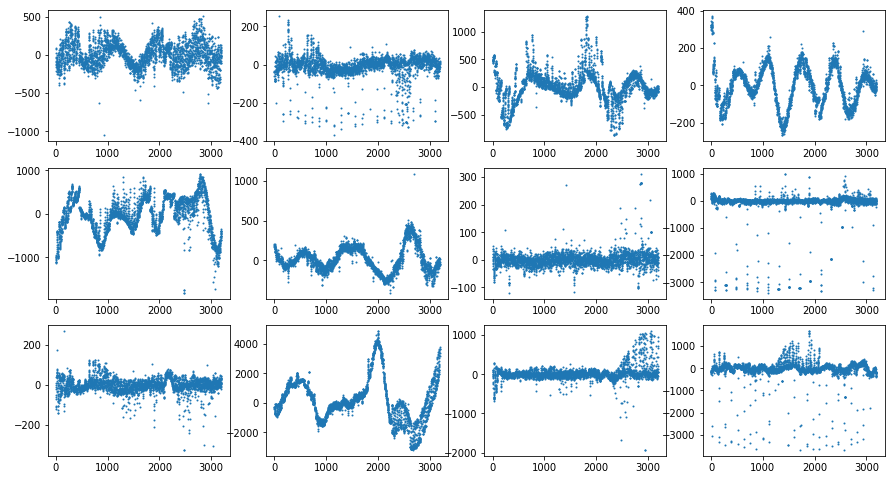

In [ ]:
#@title Run to see samples of exoplanet stars
fig = plt.figure(figsize=(15,40))
for i in range(12):
    ax = fig.add_subplot(14,4,i+1)
    ax.scatter(np.arange(3197),df_train[df_train['LABEL'] == 1].iloc[i,1:],s=1)

And now let's review what *non*-exoplanet stars look like!

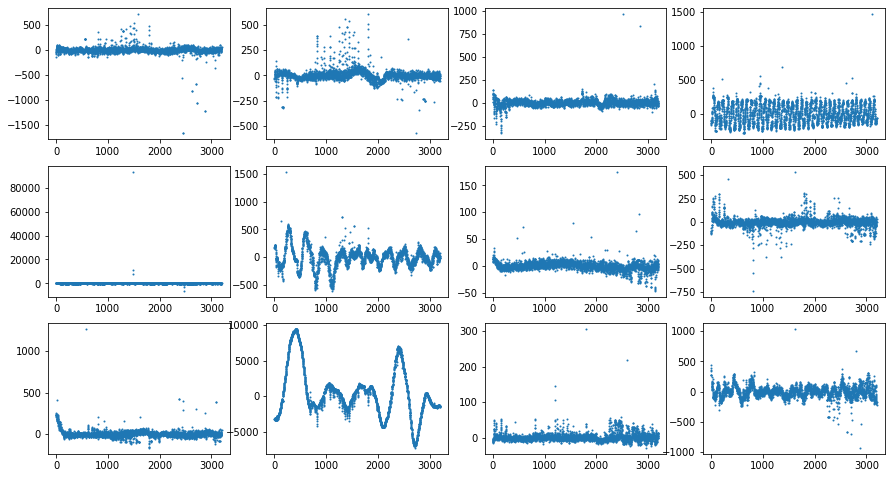

In [ ]:
#@title Run to see samples of non-exoplanet stars
fig = plt.figure(figsize=(15,40))
for i in range(12):
    ax = fig.add_subplot(14,4,i+1)
    ax.scatter(np.arange(3197),df_train[df_train['LABEL']==0].iloc[i,1:],s=1)

#### Comparing Histograms for Exoplanets vs. Non-Exoplanets

Histograms allow us to view how many times a certain value is present within a given sample. For example, this would be like counting how many times a particular value was observed. On the bottom or x-axis, this would be all of the different values of flux observed. The y-axis would represent how many times those values were observed throughout the sample.

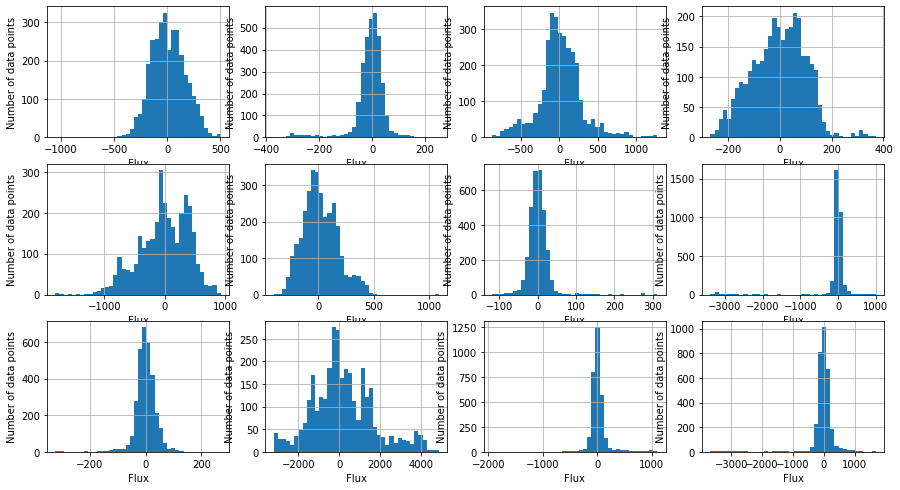

In [ ]:
#@title Run to see histograms of exoplanet stars
fig = plt.figure(figsize=(15,40))
for i in range(12):
    ax = fig.add_subplot(14,4,i+1)
    plt.xlabel("Flux")
    plt.ylabel("Number of data points")
    df_train[df_train['LABEL']==1].iloc[i,1:].hist(bins=40)

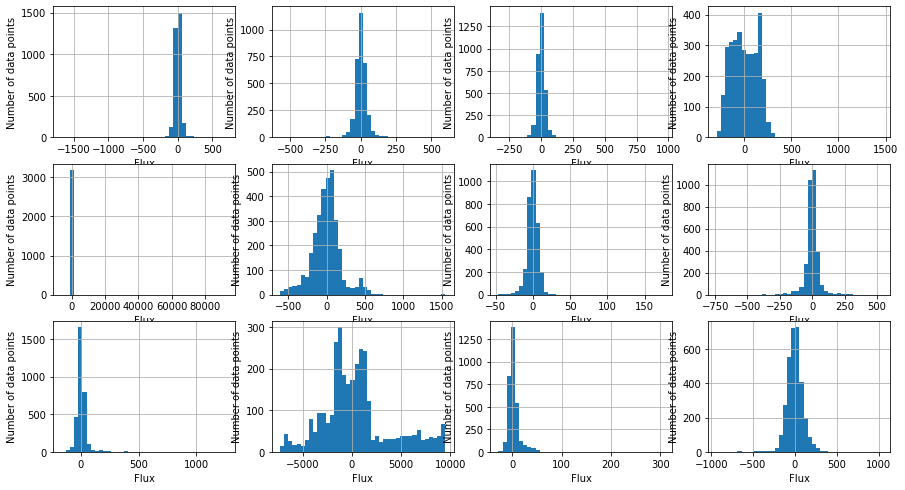

In [ ]:
#@title Run to see histograms of non-exoplanet stars
fig = plt.figure(figsize=(15,40))
for i in range(12):
    ax = fig.add_subplot(14,4,i+1)
    plt.xlabel("Flux")
    plt.ylabel("Number of data points")
    df_train[df_train['LABEL']==0].iloc[i,1:].hist(bins=40)

**Regarding the range of values in exoplanet vs. non-exoplanet stars, there are:**

* High differences in values for flux.
* Mostly less variation in non-exoplanet stars.
* However, it may also have a lot of value variation for non-exoplanet stars.
* In the latter case, the values are more equally observed or more, "flat".

**This could be a problem, but there is a way to deal with it:**

* Problem: Makes it difficult to compare patterns!
* Solution: Normalization. This will involve taking the max and min value of any flux collected in any period of time.
* We will define helper functions later to help with this.

### Counting Exoplanets

We will find out in `df_train` and `df_test` how many samples there are from an exoplanet star and how many are non-exoplanet-stars.

In [ ]:
train_with_exoplanet_samples = df_train.loc[df_train['LABEL'] == 1]
train_with_non_exoplanet_samples = df_train.loc[df_train['LABEL'] == 0]

print("exoplanet samples in train:", len(train_with_exoplanet_samples))
print("non-exoplanet samples in train:", len(train_with_non_exoplanet_samples))

test_with_exoplanet_samples = df_test.loc[df_test['LABEL'] == 1]
test_with_non_exoplanet_samples = df_test.loc[df_test['LABEL'] == 0]

print("exoplanet samples in train:", len(test_with_exoplanet_samples))
print("non-exoplanet samples in train:", len(test_with_non_exoplanet_samples))

exoplanet samples in train: 37
non-exoplanet samples in train: 5050
exoplanet samples in train: 5
non-exoplanet samples in train: 565


We will calculate the **portion** of exoplanet stars compared to the total samples, in both the traning data and the testing data.

In [ ]:
print("df_train percent:", len(train_with_exoplanet_samples)/ len(df_train))
print("df_test percent:", len(test_with_exoplanet_samples)/ len(df_test))

df_train percent: 0.007273442107332416
df_test percent: 0.008771929824561403


That's less than 1 percent!

The calculated ratios can pose a problem by having an imbalanced dataset.
Consider the following:
I am asked several hard questions on an exam. Each question have only two answer choices: A | B
The Questions themselves can be extremely difficult to study. However, I notice that ~98% of the time
that the answer is A. Would you take the time to study if you knew that you'd most likely get a 98
on the exam by only selecting A for every question?

We will be running helper functions that will help with this problem.

## Classification with KNN

Now, let's approach our problem as a classification task!

In [ ]:
#@title Run this to load helper functions and create train_X, train_y, test_X, test_y

def analyze_results(model, train_X, train_y, test_X, test_y):
    """
    Helper function to help interpret and model performance.

    Args:
    model: estimator instance
    train_X: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model training.
    train_y : array-like of shape (n_samples,)
    Target values for model training.
    test_X: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model testing.
    test_y : array-like of shape (n_samples,)
    Target values for model testing.

    Returns:
    None
    """
    print("-------------------------------------------")
    print("Model Results")
    print("")
    print("Training:")
    fig = plt.figure(figsize=(22,7))
    ax = fig.add_subplot(1,3,1)
    plot_confusion_matrix(model,train_X,train_y,ax=ax,values_format = '.0f')
    plt.show()
    print("Testing:")
    fig = plt.figure(figsize=(22,7))
    ax = fig.add_subplot(1,3,1)
    plot_confusion_matrix(model,test_X,test_y,ax=ax,values_format = '.0f')
    plt.show()

def reset(train,test):
    train_X = train.drop('LABEL', axis=1)
    train_y = train['LABEL'].values
    test_X = test.drop('LABEL', axis=1)
    test_y = test['LABEL'].values
    return train_X,train_y,test_X,test_y

train_X,train_y,test_X,test_y = reset(df_train, df_test)

#### Step 1: Create our model

Let's start by using a `KNeighborsClassifier` model, which has already been imported from [Scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [ ]:
# Create a KNN model (will train later)

n_neighbors = 5

model = KNeighborsClassifier(n_neighbors=n_neighbors)

####Step 2: Train our model

Now we train the KNN model defined on `train_X` and `train_y` using the `fit` method.

In [ ]:
# Train the Model

model.fit(train_X,train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

#### Step 3: Predictions and Accuracy

Now we calculate the `train_predictions` and `test_predictions` using the `predict` function from our model. Then we print out the results from using `accuracy_score`, previously imported from `sklearn.metrics`. This may take a while to run!

In [ ]:
# Calculate the predictions on test_X using our trained model

train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)
print(accuracy_score(train_y, train_predictions))
print(accuracy_score(test_y, test_predictions))

0.9931197169254964
0.9912280701754386


Awesome accuracy score of 0.9931!

#### Step 4: Confusion Matrices

Confusion Matrices are helpful in understanding how our model's doing and the kinds of biases it might have - even if it has a high accuracy. This might change how much we trust our model!

**Let's use the `analyze_results` method** to analyze the results of the model. This may take a while to run.

-------------------------------------------
Model Results

Training:


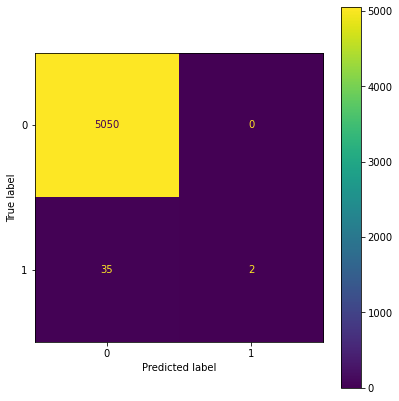

Testing:


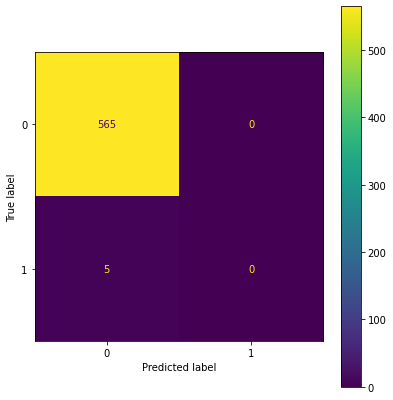

In [ ]:
# Use to analyze logistical model

analyze_results(model=model, train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)

## Logistic Regression

We might feel less confident in our KNN model after seeing the confusion matrix! Let's try out some other models.


Here, let's do what we did before, but using a Logistic Regression model instead of a KNN model! Please set up a model using the imported `LogisticRegression` object with `max_iter`=1000.

In [ ]:
# Create a model (will train later)

max_iter = 1000

model = LogisticRegression(max_iter=max_iter)

Now let's train and analyze our `model` like we did before, using both accuracy and confusion matrices.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9150776489089837
0.6403508771929824
-------------------------------------------
Model Results

Training:


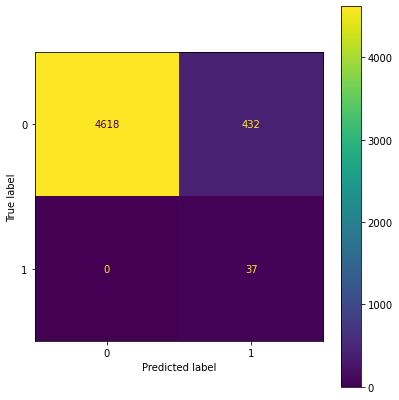

Testing:


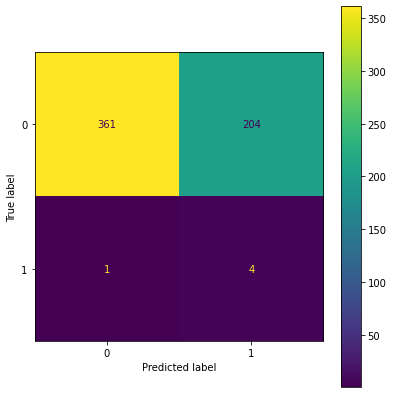

In [ ]:
# Train the model, see accuracies, and analyze the results

model.fit(train_X,train_y)

train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)
print(accuracy_score(train_y, train_predictions))
print(accuracy_score(test_y, test_predictions))

analyze_results(model=model, train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)

## Exploring Other Models

Now, let's see if we can find another classifier that combines the best of both worlds!

Let's check out the [list of classifiers](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning) from Scikit-learn.

We should choose some classifiers, try them out, and adjust the model parameters too so we can get the best possible results!

Now let's create a model!

1.0
0.9859649122807017
-------------------------------------------
Model Results

Training:


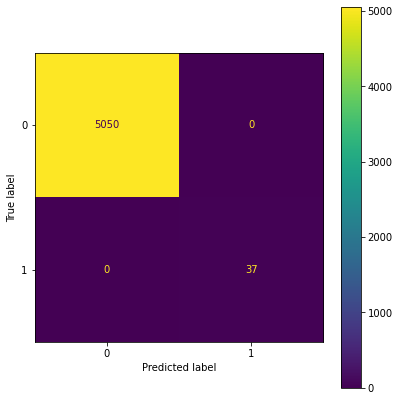

Testing:


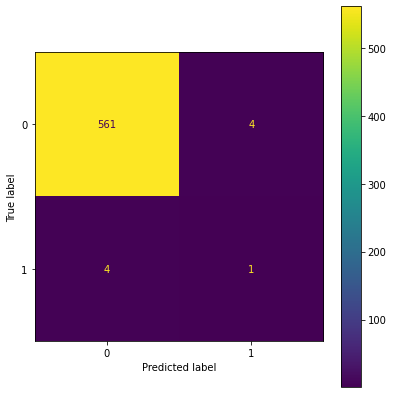

In [ ]:
## Create a Decision Tree model (answers will vary)

model = tree.DecisionTreeClassifier()


model.fit(train_X,train_y)

train_predictions = model.predict(train_X)
test_predictions = model.predict(test_X)
print(accuracy_score(train_y, train_predictions))
print(accuracy_score(test_y, test_predictions))

analyze_results(model=model, train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)

In this case, between the logistic regression and decision tree models, the logistic regression model is the best model to choose.

## Data Augmentation


In the previous training techniques, we noticed that the models may have had high levels of accuracy, but yielded poor results!

Here, we'll try to improve performance using data augmentation. We'll apply five different augmentation techniques to this dataset, and explore two of these techniques in high detail. We'll explore the use and importance of these two concepts, and compare these results with the previous results we've had as a baseline.

In [ ]:
#@title Run to define helper functions
# Helper functions that we can run for the three augmentation functions that will be used, but not explroed in depth

def smote(a,b):
    model = SMOTE()
    X,y = model.fit_sample(a, b)
    return X,y

def savgol(df1,df2):
    x = savgol_filter(df1,21,4,deriv=0)
    y = savgol_filter(df2,21,4,deriv=0)
    return x,y

def fourier(df1,df2):
    train_X = np.abs(np.fft.fft(df1, axis=1))
    test_X = np.abs(np.fft.fft(df2, axis=1))
    return train_X,test_X

def norm(df1,df2):
    train_X = normalize(df1)
    test_X = normalize(df2)
    return train_X,test_X

def robust(df1,df2):
    scaler = RobustScaler()
    train_X = scaler.fit_transform(df1)
    test_X = scaler.transform(df2)
    return train_X,test_X

Previously, we've discussed how our data can be improved. Here we'll further explore two points of previous concern:
1. Data having a high range of values
2. Data being heavily unbalanced (towards non-exoplanet stars)

### Normalization

Normalization means scaling data so all points lie between 0 and 1. In the example below, we divide everything by the maximum number.

For example, if we were to normalize the following list of values:

[0, 1, 2, 3, 4, 5]

the normalized list would be:

[0, 0.2, 0.4, 0.6, 0.8, 1]

The operations that happen to normalize the list are:

1. Find the offset between the min value and 0
2. Add the offset to each element
3. Take the absolute difference of the max value and min value
4. Then divide all elements by this difference

We will create a function that will help us do this. We explored the functions from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/preprocessing.html) and used one to help us create a function to `normalize` our `train_X` and `test_X`. Below, we complete the function `norm`.

In [ ]:
def norm(train_X, test_X):
    """
    Helper function to normalize inputs train_X and test_X.

    Args:
    train_X: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model training.
    test_X: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model testing.

    Returns:
    train_X: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model training.
    test_X: {array-like, sparse matrix} of shape (n_samples, n_features)
    Input values for model testing.
    """
    norm_train_X = normalize(train_X)
    norm_test_X = normalize(test_X)
    return norm_train_X, norm_test_X

We will now applu the norm function to our `train_X` and `test_X` variables.

In [ ]:
fourier_train_X, fourier_test_X = fourier(train_X, test_X)
savgol_train_X, savgol_test_X = savgol(fourier_train_X, fourier_test_X)

norm_train_X, norm_test_X = norm(savgol_train_X,savgol_test_X)

robust_train_X, robust_test_X = robust(norm_train_X, norm_test_X)

We didn't normalize our labels because we have binary labels for classification.
This wouldn't make a difference if the values were 0 and 1 for classification.
However, this would make a difference in how we measure success where labels 1 or 2 are expercted,
but labels 0 or 1 are given. (This would cause no issue if everything is consistently made 0 or 1)
This would apply more to if the outputs / labels were linear (regression problem)

### Data Augmentation with SMOTE

Now to tackle the problem of having an imablanced dataset! The concept that we'll use to approach this is by synthesizing new data based off of our existing to create a more balanced dataset. Essentially, we'll be creating new datapoints to have more exoplanet samples.

We'll accomplish this by using SMOTE.

SMOTE generates new data for the minority class to help balance the dataset, and to better help define classifcation regions - so the model doesn't always predict the majority class.

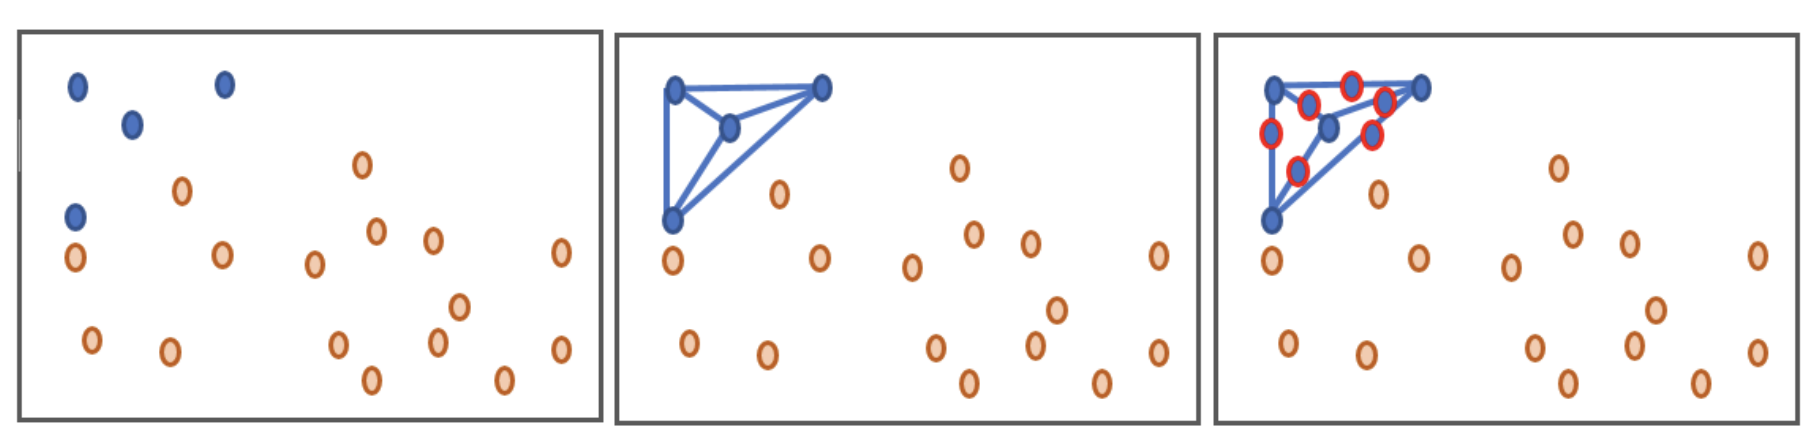

More information about SMOTE can be found [here](https://datasciencecampus.github.io/balancing-data-with-smote/).

Let's now apply this concept by generating new datapoints in `robust_train_X` and `train_Y` using our predefined helper-function `smote`. The newly generated psets will be saved under `aug_train_X`, `aug_train_y`, `aug_test_X`, and `aug_test_y`. This will stand for augmented data: data that has been manipulated and generated.



In [ ]:
smote_train_X,smote_train_y = smote(robust_train_X, train_y)

Now, let's combine our old (real) and new (augmented) data:

In [ ]:
aug_train_X, new_X_test_data, aug_train_y, new_y_test_data = train_test_split(smote_train_X, smote_train_y, test_size=0.3)
aug_test_X = np.concatenate((robust_test_X, new_X_test_data), axis=0)
aug_test_y = np.concatenate((test_y, new_y_test_data), axis=0)

Awesome!

Now let's attempt to visualize the new augmented data.



In [ ]:
#@title Run to load helper functions and variables
def visualize_data(X, y, indicies):
  stars = indicies

  fig = plt.figure(figsize=(24,500))
  x = np.array(range(3197))
  for i in range(0,len(stars)):
      ax = fig.add_subplot(100,5,1+i)
      ax.set_title('Data '+"I:"+str(stars[i])+" Label:"+str(y[stars[i]]))
      ax.scatter(x, X[stars[i],:],s=1)

robust_train_y_with_exoplanet_indicies = train_y.nonzero()[0]
robust_train_y_with_no_exoplanet_indicies = (train_y-1).nonzero()[0]

aug_train_y_with_exoplanet_indicies = aug_train_y.nonzero()[0]
aug_train_y_with_no_exoplanet_indicies = (aug_train_y-1).nonzero()[0]

Orginal, newly modified data with exoplanets:


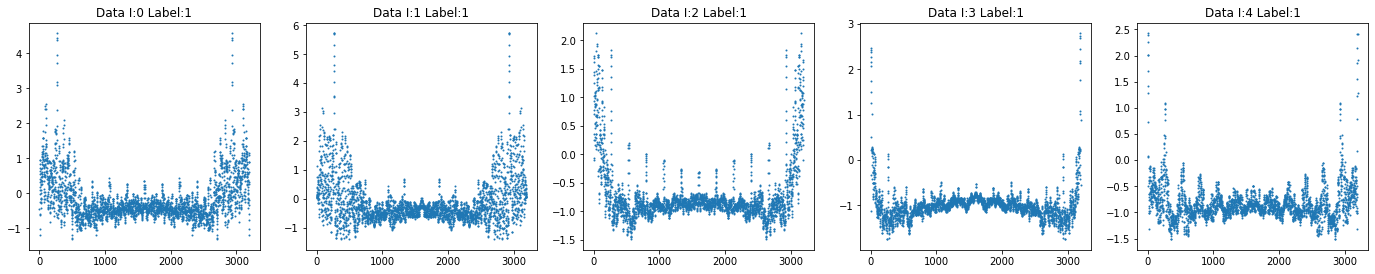

In [ ]:
#@title Run to visualize original, preprocessed data with exoplanets
print("Orginal, newly modified data with exoplanets:")
visualize_data(robust_train_X, train_y, robust_train_y_with_exoplanet_indicies[:5])

Augmented data with Exoplanets:


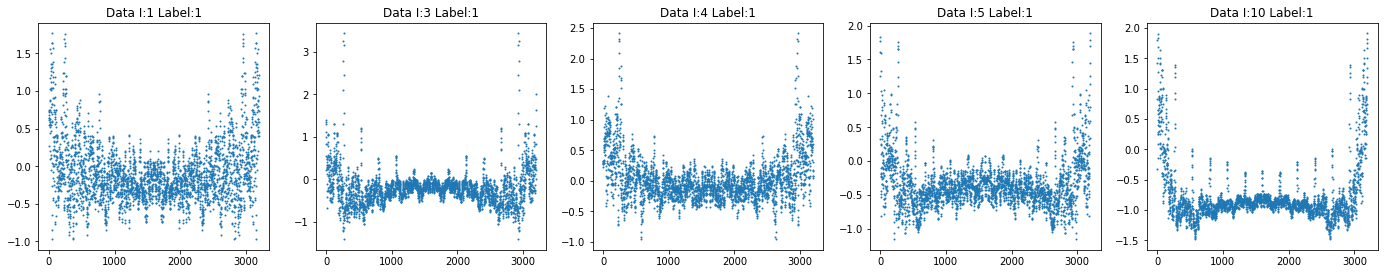

In [ ]:
#@title Run to visualize newly generated data containing exoplanets
print("Augmented data with Exoplanets:")
visualize_data(aug_train_X, aug_train_y, aug_train_y_with_exoplanet_indicies[:5])

Orginal, newly modified data with no exoplanets:


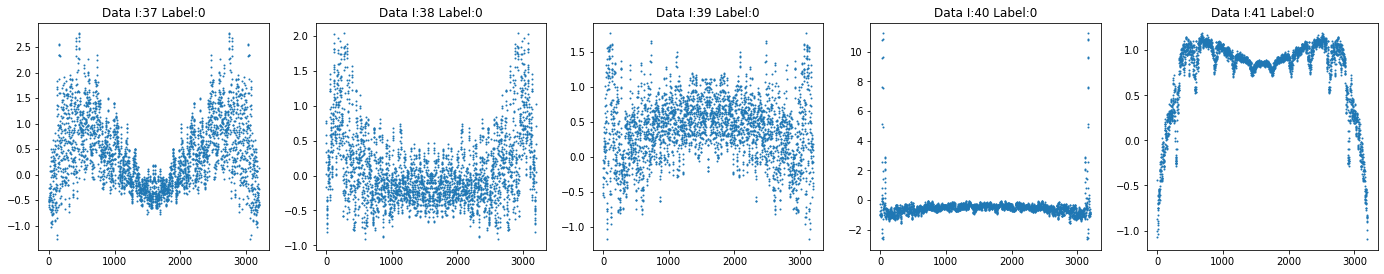

In [ ]:
#@title Run to visualize original, modified data with no Exoplanets
print("Orginal, newly modified data with no exoplanets:")
visualize_data(robust_train_X, train_y, robust_train_y_with_no_exoplanet_indicies[:5])

Augmented data with no Exoplanets:


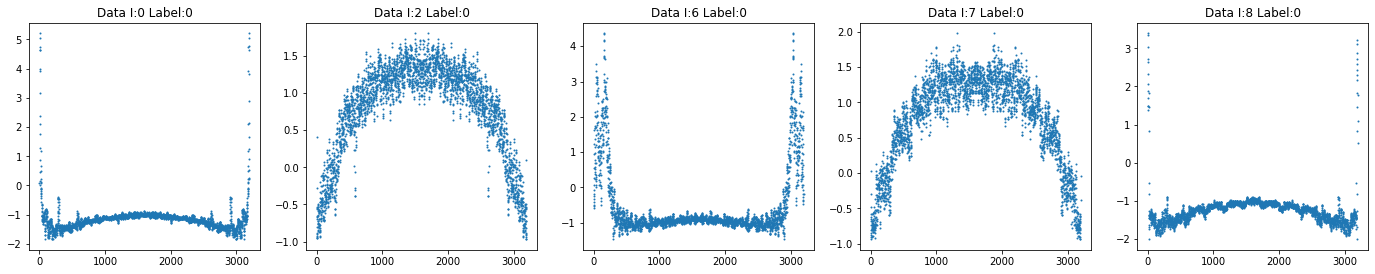

In [ ]:
#@title Run to visualize newly generated data containing no exoplanets
print("Augmented data with no Exoplanets:")
visualize_data(aug_train_X, aug_train_y, aug_train_y_with_no_exoplanet_indicies[:5])

Now we will find out how many training samples we have. Out of these, we can find how many are exoplant samples and non-exoplanet samples.

In [ ]:
print("train_y len:", len(aug_train_y))

number_of_exoplanet_samples = np.count_nonzero(aug_train_y == 1)
number_of_non_exoplanet_samples = np.count_nonzero(aug_train_y == 0)

print("exoplanet samples in train_y:", number_of_exoplanet_samples)
print("non-exoplanet samples in train_y:", number_of_non_exoplanet_samples)

train_y len: 7070
exoplanet samples in train_y: 3514
non-exoplanet samples in train_y: 3556


That looks more balanced!

Some things that we notice with this new split ratio is that the data set is closer to a 50/50 representation. Thus, we should expect the model to be more likely to learn trends rather than assuming any sample will be a smaple of the majority class (non-exoplanet stars).

### Using Augmented Data


Now let's find out how the augmentation affects the results with a past architecture using the new data.
We will pick the model that performed best from before and re-train it with the new augmented data.

-------------------------------------------
Model Results

Training:


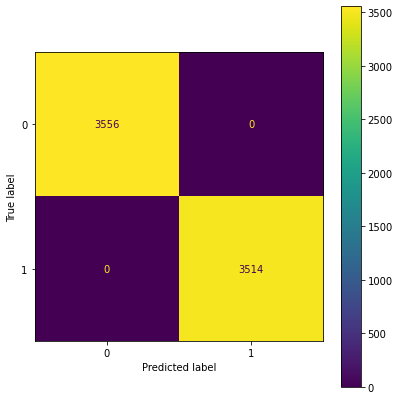

Testing:


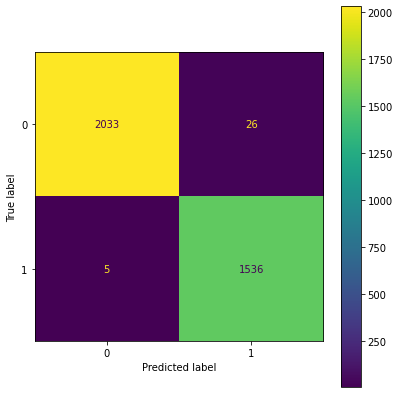

In [ ]:
# Create a model (will train later)

model = tree.DecisionTreeClassifier()
model.fit(aug_train_X, aug_train_y)
analyze_results(model=model, train_X=aug_train_X, train_y=aug_train_y, test_X=aug_test_X, test_y=aug_test_y)


The model now became better due to the comparative ratios of samples classified correctly. This implies that better, general learning has occured from our models.

To improve mistakes our classifier made, we can conduct hyper-parameter tuning and more/different data augmentation. We can also do fine tuning of data augmentation via the hidden hyper-parameters.